<a href="https://colab.research.google.com/github/nhornos/CovidApp/blob/test/HPC/Cuaderno_2_martes_grupo9_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 - Introducción:
Decidimos implementar una funcionalidad que nos permita fusionar dos imágenes, con múltiples propósitos. Uno de ellos puede ser el de introducir un fondo a una imagen, otro puede ser el de eliminar algún objeto en particular de una imagen, entre otros.
Lo que debemos saber es que el algoritmo recibirá dos imágenes: la original y la imagen a filtrar. El comportamiento del algoritmo será que, dentro de la imagen a filtrar, reemplazará todos los pixeles verdes por los pixeles en la misma posición de la imagen original. De esta manera, si la imagen original es un paisaje y la imagen a filtrar es un perro con todo el fondo verde, la imagen resultado será el perro con el paisaje de fondo.

Procedemos a implementar el algoritmo ejecutando en CPU, y luego en GPU con CUDA (de forma que podamos aplicar HPC ya que estamos manejando grandes volúmenes de datos). 

Se compararán los tiempos de ejecución en cada caso.

# 2 - Armado del ambiente

In [ ]:
#@title ## 2.1 Parámetros de ejecución
#@markdown ---
#@markdown ### Especifique la URL de la imagen original y la imagen a filtrar:
url_imagen_original = "https://raw.githubusercontent.com/nhornos/CovidApp/prod/HPC/FondoMario.jpg" #@param {type:"string"}
url_imagen_a_filtrar = "https://raw.githubusercontent.com/nhornos/CovidApp/prod/HPC/ImagenMario.jpg" #@param {type:"string"}

#@markdown ---
# Leo la imagen desde internet.
#!wget https://github.com/wvaliente/SOA_HPC/blob/main/unlam.jpg?raw=true -O imagen.jpg

# TODO: Mejorar información y resultado de ejecución. 
!wget {url_imagen_original} -O imagenOriginal.jpg
!wget {url_imagen_a_filtrar} -O imagenAFiltrar.jpg


--2021-07-04 22:05:58--  https://raw.githubusercontent.com/nhornos/CovidApp/prod/HPC/FondoMario.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 176130 (172K) [image/jpeg]
Saving to: ‘imagenOriginal.jpg’

imagenOriginal.jpg  100%[===================>] 172.00K  --.-KB/s    in 0.005s  

2021-07-04 22:05:58 (31.2 MB/s) - ‘imagenOriginal.jpg’ saved [176130/176130]

--2021-07-04 22:05:58--  https://raw.githubusercontent.com/nhornos/CovidApp/prod/HPC/ImagenMario.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34603 (34K) [image/j

In [ ]:
#@title ## 2.2 Instalación de la biblioteca pycuda
#@markdown ##### Esta biblioteca debe ser instalada previamente para poder ejecutar el algoritmo en GPU
!pip install pycuda

     |████████████████████████████████| 1.7MB 36.5MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 71kB 9.2MB/s 
     |████████████████████████████████| 81kB 11.3MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=627583 sha256=70a2158256aec78caaa0688e54dd2589c136ae61931e5d0cb70dc4a3343dcf56
  Stored in directory: /root/.cache/pip/wheels/d5/55/64/fd4dddcc5f1c25eebd90b5291c3769101dc978c70165685512
Successfully built pycuda
  Created wheel for pytools: filename=pytools-2021.2.7-py2.py3-none-any.whl size=60644 sha256=7d6d8c9cba1031c73bff6698fb68716f19d855a6e5e6b543c46306f5e7b586ad
  Stored in directory: /root/.cache/pip/wheels/a0/b5/e5/e65d25997fd77729b9aa214645add18688483e48bbcbab6ffc
Successfully built pytools


#3 - Desarrollo CPU

Tiempo de conversión de imagen: 15734.418 [ms]
Tiempo Total: 15886.754 [ms]


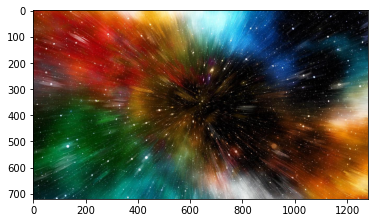

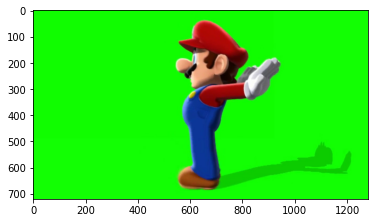

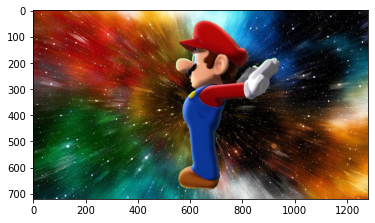

In [ ]:
# ESTE ES EL CODIGO DEL EJERCICIO 1. CAMBIARLO
%matplotlib inline
from datetime import datetime

tiempo_total = datetime.now()

import matplotlib.pyplot as plt
import numpy
from PIL import Image 
import sys;

# --------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
# --------------------------------------------

#-------------------------------------------
# Definición función que aplica la transformación a cada color de un pixel
def reemplazarPixelesVerdesPorOriginales(pRojo, pVerde, pAzul):
  if pVerde > (pRojo + 20) and pVerde > (pAzul + 20) and (pRojo + pAzul) < 250 and (125 > (pRojo - pAzul) > -125):
    return True
  return False
#-------------------------------------------

#Manejo excepción archivo
try:
  img_nombre = 'imagenOriginal.jpg'
  imageOrig = Image.open( img_nombre )

  img_nombre = 'imagenAFiltrar.jpg'
  imageAFilt = Image.open( img_nombre )
except FileNotFoundError:
  sys.exit("Error. No existe la imagen " + img_nombre + " en el ambiente.")
# Obtengo las proporciones de la imagen. 
imgOrig_ancho, imgOrig_alto  = imageOrig.size 
imgAFilt_ancho, imgAFilt_alto  = imageAFilt.size

try:
  if imgOrig_ancho != imgAFilt_ancho or imgOrig_alto != imgAFilt_alto:
    raise Exception()  
except Exception as ex:
  sys.exit("Error. Las imágenes deben tener el mismo tamaño.")

# Convierto las 2 imagenes origen comprimidas en JPEG/PNG a array
imgOrig_cpu = numpy.asarray(imageOrig)
imgOrig_cpu = imgOrig_cpu.astype( numpy.int32() )

imgAFilt_cpu = numpy.asarray(imageAFilt)
imgAFilt_cpu = imgAFilt_cpu.astype( numpy.int32() )

# Genero el array resultado.
img_R_cpu = numpy.empty_like( imgOrig_cpu)

# Muestro los atributos de la imagen y como se ve antes del seudo filtro.
#print("Imagen original: " + img_nombre + " -" + imageOrig.mode + "- [" + str(img_ancho) + ", " + str(img_alto ) + "]" )  

# Muestro la imagen Original.
plt.figure()
imgplot=plt.imshow( imgOrig_cpu )

# Muestro la imagen a filtrar.
plt.figure()
imgplot=plt.imshow( imgAFilt_cpu )

tiempo_img = datetime.now()

# Convierto la imagen a escala de grises
for y  in range( 0, imgOrig_alto ):
  for x in range( 0, imgOrig_ancho ):
    pixel_R, pixel_G, pixel_B = imgAFilt_cpu[y][x]
    if reemplazarPixelesVerdesPorOriginales(pixel_R, pixel_G, pixel_B):
      pixel_R, pixel_G, pixel_B = imgOrig_cpu[y][x]
    
    img_R_cpu[y][x] = [pixel_R, pixel_G, pixel_B]

tiempo_img = datetime.now() - tiempo_img

# Muestro la imagen luego de aplicarle el filtro.
plt.figure()
imgplot = plt.imshow( img_R_cpu )

tiempo_total = datetime.now() - tiempo_total

print( "Tiempo de conversión de imagen:", tiempo_en_ms( tiempo_img   ), "[ms]" )
print( "Tiempo Total:",                   tiempo_en_ms( tiempo_total ), "[ms]" )

# 4 - Desarrollo GPU

Thread: [ 16 , 19  ], Bloque : [ 80 , 38 ]
Total de Thread: [ 1280 , 722  ]  =  924160
Tiempo de conversión de imagen:  0.276 [ms]
Tiempo TOTAL:  126.665 [ms]


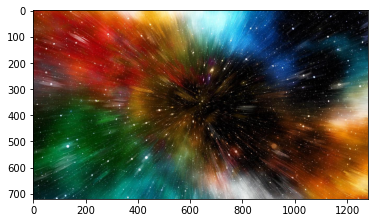

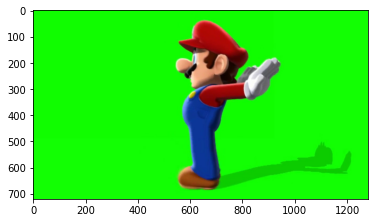

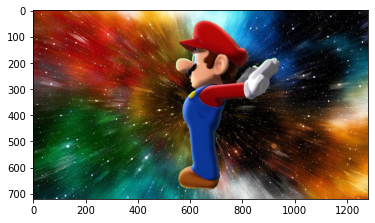

In [ ]:
%matplotlib inline
from datetime import datetime
tiempo_total = datetime.now()

import matplotlib.pyplot as plt
import numpy
from PIL import Image 
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import sys;

# --------------------------------------------
# Definición de función que transforma el tiempo en milisegundos
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
# --------------------------------------------

#Manejo excepción archivo
try:
  img_nombre = 'imagenOriginal.jpg'
  imageOrig = Image.open( img_nombre )

  img_nombre = 'imagenAFiltrar.jpg'
  imageAFilt = Image.open( img_nombre ) 
except FileNotFoundError:
  sys.exit("Error. No existe la imagen " + img_nombre + " en el ambiente.")
  
# Obtengo las proporciones de la imagen. 
imgOrig_ancho, imgOrig_alto  = imageOrig.size 
imgAFilt_ancho, imgAFilt_alto  = imageAFilt.size 

try:
  if imgOrig_ancho != imgAFilt_ancho or imgOrig_alto != imgAFilt_alto:
    raise Exception()  
except Exception as ex:
  sys.exit("Error. Las imágenes deben tener el mismo tamaño.")

# Convierto las 2 imagenes origen comprimidas en JPEG/PNG a array
imgOrig_cpu = numpy.asarray(imageOrig)
imgOrig_cpu = imgOrig_cpu.astype( numpy.int32() )

imgAFilt_cpu = numpy.asarray(imageAFilt)
imgAFilt_cpu = imgAFilt_cpu.astype( numpy.int32() )

img_R_cpu = numpy.empty_like( imgOrig_cpu)

# Reservo los 3 vectores en GPU(3 pixeles usa RGB * (el tamaño del array))
imgOrig_gpu = cuda.mem_alloc( imgOrig_cpu.nbytes )
imgAFilt_gpu = cuda.mem_alloc( imgAFilt_cpu.nbytes )

img_R_gpu = cuda.mem_alloc( img_R_cpu.nbytes )

# GPU - Copio la memoria al GPU.
cuda.memcpy_htod( imgOrig_gpu, imgOrig_cpu )
cuda.memcpy_htod( imgAFilt_gpu, imgAFilt_cpu )

cuda.memcpy_htod( img_R_gpu, img_R_cpu )

# CPU - Defino la función kernel que ejecutará en GPU.
module = SourceModule("""
/////////////////////////////// PRUEBAS DE RANGOS ///////////////////////////////
  //if(pRojo < 120 && pVerde > 150 && pAzul < 120){
  //if(pRojo < 100 && pVerde > 110 && pAzul < 100){
  //if(pVerde > (pRojo + 20) && pVerde > (pAzul + 20) && (10 >(pRojo-pAzul) > -10)){
/////////////////////////////////////////////////////////////////////////////////
__device__ int reemplazarPixelesVerdesPorOriginales(float pRojo, float pVerde, float pAzul){
  if(pVerde > (pRojo + 20) && pVerde > (pAzul + 20) && (pRojo + pAzul) < 250 && (125 >(pRojo-pAzul) > -125)){
    return 1;
  }
  return 0;
}
__global__ void kernel_img( int ancho, int alto, int *img_Orig, int *img_AFilt, int *img_R )
{
  // Calculo las coordenadas del Thread en dos dimensiones.
  int idx = threadIdx.x + blockIdx.x*blockDim.x;
  int idy = threadIdx.y + blockIdx.y*blockDim.y;
  float fRojo;
  float fVerde;
  float fAzul;

  // Verifico que los Thread, esten dentro de las dimensiones de la imagen.
  if( idx < ancho && idy < alto )
  {
    // Aumento el brillo por el escalar definido

    fRojo = (float)img_AFilt[(idx+(idy*ancho))*3]; // Componente Rojo del pixel.
    fVerde = (float)img_AFilt[((idx+(idy*ancho))*3)+1]; // Componente Verde del pixel.
    fAzul = (float)img_AFilt[((idx+(idy*ancho))*3)+2]; // Componente Azul del pixel.

    if(reemplazarPixelesVerdesPorOriginales(fRojo, fVerde, fAzul) == 1){
      fRojo = (float)img_Orig[(idx+(idy*ancho))*3]; // Componente Rojo del pixel.
      fVerde = (float)img_Orig[((idx+(idy*ancho))*3)+1]; // Componente Verde del pixel.
      fAzul = (float)img_Orig[((idx+(idy*ancho))*3)+2]; // Componente Azul del pixel.
    }

    // Escribo el color del pixel.
    img_R[(idx+(idy*ancho))*3  ] = (int) fRojo;
    img_R[(idx+(idy*ancho))*3+1] = (int) fVerde;
    img_R[(idx+(idy*ancho))*3+2] = (int) fAzul;
  }

}
""")

# Muestro los atributos de la imagen y como se ve antes del seudo filtro.
#print("Imagen del filtro: " + img_nombre + " -" + image.mode + "- [" + str(img_ancho) + ", " + str(img_alto ) + "]" )  

# CPU - Genero la función kernel.
kernel = module.get_function("kernel_img")

tiempo_img = datetime.now()

dim_hilo_x = 16
dim_bloque_x = numpy.int( (imgOrig_ancho+dim_hilo_x-1) / dim_hilo_x )

dim_hilo_y = 19
dim_bloque_y = numpy.int( (imgOrig_alto+dim_hilo_y-1) / dim_hilo_y )

print( "Thread: [", dim_hilo_x, ",", dim_hilo_y, " ], Bloque : [", dim_bloque_x, ",", dim_bloque_y, "]" )
print( "Total de Thread: [", dim_hilo_x*dim_bloque_x, ",", dim_hilo_y*dim_bloque_y, " ]", " = ", dim_hilo_x*dim_bloque_x*dim_hilo_y*dim_bloque_y )

tiempo_img = datetime.now()

kernel(numpy.int32(imgOrig_ancho), numpy.int32(imgOrig_alto), imgOrig_gpu, imgAFilt_gpu, img_R_gpu, block=( dim_hilo_x, dim_hilo_y, 1 ), grid=(dim_bloque_x, dim_bloque_y,1) )

tiempo_img = datetime.now() - tiempo_img

# GPU - Copio el resultado desde la memoria GPU.
cuda.memcpy_dtoh( img_R_cpu, img_R_gpu )

# Muestro la imagen Original.
plt.figure()
imgplot=plt.imshow( imgOrig_cpu )

# Muestro la imagen a filtrar.
plt.figure()
imgplot=plt.imshow( imgAFilt_cpu )

# Muestro la imagen luego de aplicarle el filtro.
plt.figure()
imgplot=plt.imshow( img_R_cpu )

tiempo_total = datetime.now() - tiempo_total

print("Tiempo de conversión de imagen: ", tiempo_en_ms( tiempo_img ), "[ms]" )
print("Tiempo TOTAL: ", tiempo_en_ms( tiempo_total ), "[ms]" )

# 5 - Métricas

En esta sección detallaremos los datos de ejecución obtenidos en la ejecución con CPU y GPU.

## 5.1 - CPU
Inicialmente se ejecutó el código en CPU. Los valores de tiempo arrojados son los siguientes:

**Tiempo de conversión de imagen: 15734.418 [ms]**

**Tiempo Total: 15886.754 [ms]**

## 5.2 - GPU

Luego de la ejecución por CPU, se ejecutó el mismo código adaptado en GPU. Los valores de tiempo que arrojó la ejecución fueron los siguientes:

**Tiempo de conversión de imagen:  0.276 [ms]**

**Tiempo TOTAL:  126.665 [ms]**

# 6 - Conclusiones
A partir de este algoritmo que desarrollamos nos queda aún más clara la importancia de utilizar GPU para manejar grandes volúmenes de datos. Decimos esto ya que, el ejercicio 1 sólo se trataba de multiplicar un escalar a cada uno de los pixeles y nada más, mientras que en éste segundo ejercicio, le agregamos la complejidad de aplicar un condicional a cada uno de los píxeles, dando como resultado, el doble del tiempo de ejecución en CPU con respecto al ejercicio 1. Es decir que, cuanto más complejo sea el algoritmo, más tardará la ejecución en CPU. Mientras que, al ejecutarlo en GPU, el tiempo de conversión de la imagen para ambos ejercicios fue casi idéntico.

# 7 - Bibiliografía
https://www.colorspire.com/rgb-color-wheel/
